Philippe Joly 2025-08-11

# PFB Algorithm Test Notebook

This notebook explores the PFB and inverse PFB

In [4]:
import numpy as np
from scipy.fft import rfft, irfft
import numba as nb
import matplotlib.pyplot as plt

## PFB 

In [28]:
osamp= 64
ntap = 4

### Weights 

In [16]:
def sinc_hamming(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hamming(ntap*lblock)*np.sinc(w/lblock)

def sinc_hanning(ntap,lblock):
    N=ntap*lblock
    w=np.arange(0,N)-N/2
    return np.hanning(ntap*lblock)*np.sinc(w/lblock)
    
def get_window(ntap, osamp, nchan=2049, ham=True):
    l_win = 2*(nchan-1)
    if ham:
        dwin = sinc_hamming(ntap, l_win * osamp)
    else:
        dwin = sinc_hanning(ntap, l_win *osamp)
    cupy_win_big = np.asarray(dwin, dtype='float32', order='c')
    return cupy_win_big

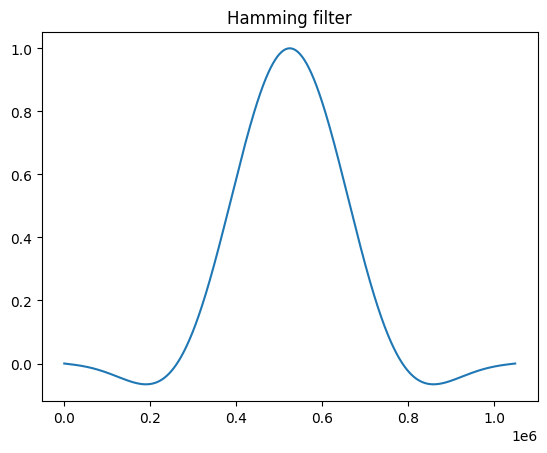

In [29]:
win = get_window(ntap,osamp, ham=True)
plt.plot(np.arange(win.size), win.flat)
plt.title("Hamming filter")
plt.show()

### Actual PFB 

In [18]:
def pfb(timestream, win, out=None, nchan=2049, ntap=4):
    lblock = 2*(nchan-1)
    nblock = timestream.size // lblock - (ntap - 1)
    timestream=timestream.reshape(-1,lblock)
    
    if out is not None:
        assert out.shape == (nblock, nchan)
        
    win=win.reshape(ntap,lblock)
    
    y = timestream[0:nblock] * win[0]
    
    # Accumulate remaining taps in-place
    for i in range(1, ntap):
        y += timestream[i:nblock+i] * win[i]
        
    out = rfft(y,axis=1)
    return out

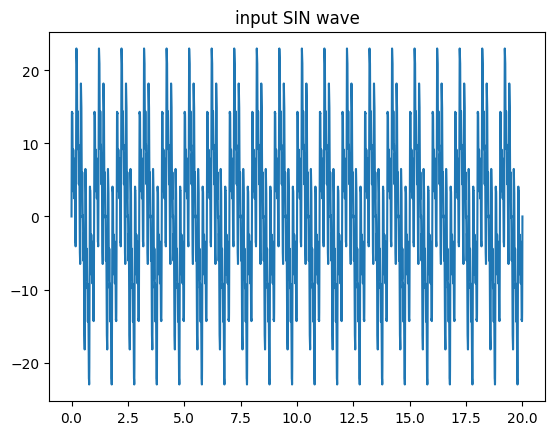

In [50]:
# Sin wave example
f = [1, 5, 10, 15, 30]
amp = [10,8,6,4,2]
lblock = 4096*osamp
ts_x = np.linspace(0,20, lblock*10)
ts = np.zeros_like(ts_x)
for i in range(len(f)):
    ts += amp[i]*np.sin(2*np.pi*f[i]*ts_x)

plt.title("input SIN wave")
plt.plot(ts_x, ts)
plt.show()

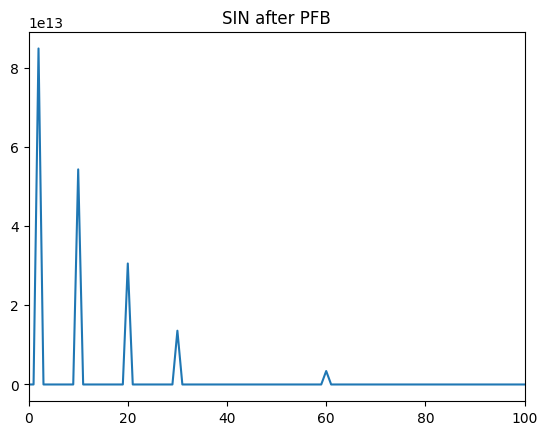

In [64]:
out = pfb(ts, win, nchan=2048*osamp+1)
plt.plot((np.abs(np.sum(out, axis=0))**2))
plt.xlim(0,100)
plt.title("SIN after PFB")
plt.show()

## IPFB 

In [68]:
acclen = 130873
cut = 100
filt_thresh = 0.45

### Filter

In [70]:
def get_matft(nslice,nchan=2049,ntap=4):
    nn=2*(nchan-1)
    dwin=sinc_hamming(ntap,nn)
    cupy_win=np.asarray(dwin,dtype='float32',order='c')
    cupy_win=np.reshape(cupy_win,[ntap,len(cupy_win)//ntap])
    mat=np.zeros((nslice,nn),dtype='float32',order='c')
    mat[:ntap,:]=cupy_win

    # Frees memory
    cupy_win = None
    mat=mat.T.copy()
    matft=rfft(mat,axis=1)
    
    return matft
    
def calculate_filter(matft, thresh):
    filt = 1/np.conj(matft)

    if thresh>0:
        abs_mat_sq = np.abs(matft)**2
        filt *= abs_mat_sq/(thresh**2+abs_mat_sq)*(1.+thresh**2)
    
    return filt

In [71]:
matft = get_matft(acclen+2*cut)
filt = calculate_filter(matft, filt_thresh)

## Actual IPFB

In [88]:
def ipfb(dat,filt):
    dd=irfft(dat, axis=1)

    dd2=dd.T.copy()
    ddft=rfft(dd2, axis=1)

    ddft=ddft*filt

    res = irfft(ddft, axis=1)
    res=res.T
    return res

In [89]:
new_ts = ipfb(out[0], filt)

IndexError: tuple index out of range